In [1]:
import os
import cv2
import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
import torch
from gestures.configs import new_config as cfg1
# from gestures.data_loader1.load import get_data_loader

# from gestures.data_loader.tiny_data_loader import get_tiny_data_loader
# from gestures.network.runner import Runner
from gestures.setup import setup_callbacks, setup_model




In [2]:
from gestures.data_loader2.dataset_factory import *
from gestures.utils_processing_data import *
files = os.listdir("/Users/netanelblumenfeld/Downloads/11G/tt")
gestures = [
    "PinchIndex",
    "PinchPinky",
    "FingerSlider",
    "FingerRub",
    "SlowSwipeRL",
    "FastSwipeRL",
    "Push",
    "Pull",
    "PalmTilt",
    "Circle",
    "PalmHold",
    "NoHand",
]
base_dir = "/Users/netanelblumenfeld/Downloads/11G/tt"
data_loader = get_data_loader("sr_classifier", files, 6, gestures, base_dir)


In [3]:
for x,y in data_loader:
    print(x.shape)
    print(y[0].shape)
    break

torch.Size([6, 5, 2, 2, 32, 496])
torch.Size([6, 5, 2, 2, 32, 492])


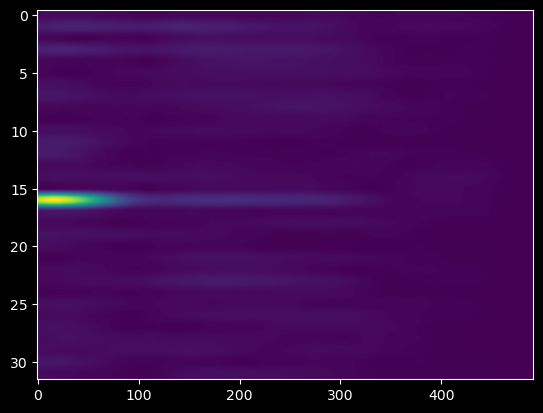

In [4]:
img = y[0]
img = RealToComplexBatch()(img)
img = DopplerMapBatch()(img)
plt.imshow(img[0,0,0].numpy(), aspect='auto')

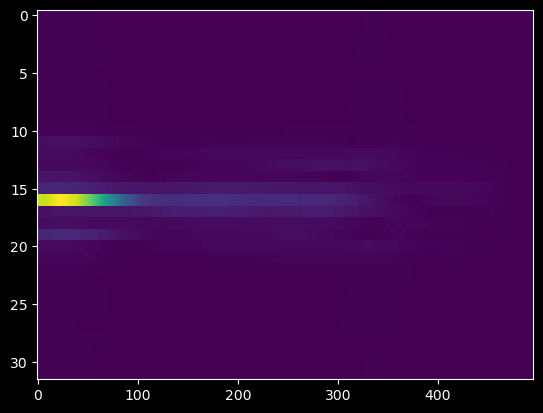

In [5]:
x1 = RealToComplexBatch()(x)
x2 = DopplerMapBatch()(x1)
plt.imshow(x2[0][0,0].numpy(), aspect='auto')

In [6]:
x2[0][0,0].numpy()[0:5]

array([[0.10967669, 0.10967669, 0.10967669, ..., 0.        , 0.        ,
        0.        ],
       [0.11101452, 0.11101452, 0.11101452, ..., 0.        , 0.        ,
        0.        ],
       [0.11164653, 0.11164653, 0.11164653, ..., 0.        , 0.        ,
        0.        ],
       [0.10007119, 0.10007119, 0.10007119, ..., 0.        , 0.        ,
        0.        ],
       [0.13359667, 0.13359667, 0.13359667, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)